In [2]:
%matplotlib inline
import glob
import json
import matplotlib
import os
import sys
from collections import defaultdict, OrderedDict, Counter
import common.util as ut
from itertools import izip
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, r2_score, precision_recall_fscore_support
import common.metrics as met
import common.plots as plo
from common.h5py_loading import load_target_map, load_dataset
from common.h5py_data_loader import H5pyDataLoader
from common.prediction_analysis import df_from_chembl_export, intersect_truth_prediction
from lasagne_nn.run_nn import get_predictions_of_knowns, get_network_from_weights
from lasagne_nn.output_loader import df_from_prediction_path
import cPickle as pkl
# setups
matplotlib.rcParams['savefig.dpi'] = 300
context = 'paper'

    
##### misc functions #####
class  Experiment(dict):
    def __init__(self, name):
        self.name = name
        self.folds = []
        self.converged_epochs = []
        self.trained_paths = []
      
    def __repr__(self):
        return str(vars(self))
    
    def __str__(self):
        return json.dumps(vars(self), indent=2)
        
    def set_converged_epoch(self, epoch, train_path, fold=None):        
        self.folds.append(fold)
        self.converged_epochs.append(epoch)
        self.trained_paths.append(train_path)

        
def long_substr(data):
    """
    Joins filename
    
    Params
    ========
    data : str
        where to find experiment results and logs

    Returns
    ========
    substr : str
        joined data
    """
    substr = ''
    if len(data) > 1 and len(data[0]) > 0:
        for i in range(len(data[0])):
            for j in range(len(data[0])-i+1):
                if j > len(substr) and all(data[0][i:i+j] in x for x in data):
                    substr = data[0][i:i+j]
    return substr


def get_expts(expt_json):
    """
    Given a filename for a pnr experiment that contains converged epochs, 
    
    Parameters
    ----------
    expt_json : str
        *.json containing experiment converged epochs, folds, and paths

    Returns
    -------
    expt_epochs_json : list of Experiment
        list of class Experiment containing names, trained_paths, folds, and converged epochs for an experiment

    """
    converged_epochs = (expt_json)
    with open(converged_epochs, "r") as fp:
        expts = json.load(fp)
    experiments = []
    for e in expts:
        tmp = Experiment(e["name"])
        for epoch, path, fold in izip(e["converged_epochs"], e["trained_paths"], e["folds"]):
            tmp.set_converged_epoch(epoch, path, fold)
        experiments.append(tmp)
        del(tmp)    
    return experiments


##### Filesystem handler functions #####

def get_env_var(handle):
    """Get an environment variable given the handle for the bash variable
    
    Params
    ========
    handle : str
        handle for a bash variable
        
    Returns
    ========
    tmp : str
        environment variable as a string
    """ 
    tmp = os.getenv(handle)
    if not tmp:
        raise LookupError("Environment variable: {} not set.".format(handle))
    return tmp.strip("'")



def find(pattern, path, dironly=False):
    """
    find by regex pattern in path
    
    Params
    ========
    pattern : str
        regex to find
    path : str
        path to search for regex
        
    Kwargs
    ========
    dironly : bool
        whether to report the file (False) or directory (True) when pattern found (Default: False)
        
    Returns
    ========
    result : list of str
        list of files or dirs containing pattern
    """
    result = []
    for root, dirs, files in os.walk(os.path.abspath(path)):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                if dironly:
                    result.append(root)
                    break
                else:
                    result.append(os.path.join(root, name))
    return result


##### Data reader functions #####

def get_easy_percentages(df):
    df['enforced_neg_percent'] = (100 / (1 + df['positive_negative_ratio']))
    df['ppos'] = 100 - df["enforced_neg_percent"]
    df.loc[df['positive_negative_ratio'] == 0.0, 'enforced_neg_percent'] = 0.0
    df.loc[df['positive_negative_ratio'] == 0.0, 'ppos'] = 100.0  
    df = df.sort_values('enforced_neg_percent')
    return df


##### Plotting functions #####

def set_nice_spines(ax=None, sides=('left', 'bottom'), color="black", linewidth=1.5):
    """
    Nice spine formatting for plots
    """
    if not ax:
        ax = plt.gca()
    for side in sides:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_color(color)
        ax.spines[side].set_linewidth(linewidth)
        
        
def get_sneg_pnrs(resdf, metric, expt_epochs_json):
    """
    get sneg pnrs for plotting based on a pre-determined set of converged epochs
    
    Parameters
    ----------
    resdf : pd.DataFrame
        pandas dataframe containing experiment metrics and info
    metric : str
        metric of interest (e.g. r2_train)
    expt_epochs_json : list of dicts
        list of dicts containing: trained_paths, folds, and converged epochs for an experiment

    Returns
    -------
    metric_df : pd.DataFrame
        dataframe containing the metric of interest at a converged epoch along with some other reporting metrics
    """
    
    metric_df = get_assigned_epochs(resdf, expt_epochs_json)
    metric_df = metric_df.sort_values('positive_negative_ratio')
    metric_df = metric_df[['positive_negative_ratio','epoch', 'train_directory', metric]]
    metric_df['is_mean'] = False
    metric_df = metric_df.rename(index=str, columns={'Score':metric})
#     metric_df['positive_negative_ratio'] = np.asarray(metric_df['positive_negative_ratio'].values, dtype=np.int)
    metric_df['enforced_neg_percent'] = (100 / (1 + metric_df['positive_negative_ratio']))
    metric_df['ppos'] = 100 - (100 / (1 + metric_df['positive_negative_ratio']))
    metric_df.loc[metric_df['positive_negative_ratio'] == 0.0, 'enforced_neg_percent'] = 0.0
    metric_df.loc[metric_df['positive_negative_ratio'] == 0.0, 'ppos'] = 100.0
    metric_df = metric_df.sort_values('enforced_neg_percent')
    base_lcs = long_substr(metric_df['train_directory'].values.tolist())
    metric_df = metric_df.sort_values(['enforced_neg_percent', 'train_directory'])
    return metric_df


def plot_metrics_by_pnr(resdf, metrics, palette=None, metric_names=None, label_suffix='', linestyle='-', hatch=''):  
    """
    Plots a positive-negative ratio experiment given a dataframe of experiments, metrics of interest, and a list of converged epochs
    
    Parameters
    ----------
    df : pd.DataFrame
        pandas dataframe containing experiment metrics and info
    metric : str
        metric of interest (e.g. r2_train)
    expt_epochs_json : list of dicts
        list of dicts containing: trained_paths, folds, and converged epochs for an experiment
        
    Kwargs
    -------
    metric_names : list
        list of names for provided metrics
    label_suffix : str
        Name to add to end of legend names (Default '')
    linestyle : str
        matplotlib plotting variable for linestyle (Default '-')
    hatch : str
        What hatch to use for matplotlib filling of fold variance (Default '')
    """
    if metric_names is None:
        metric_names = list(metrics)
    if not palette:
        palette = sns.color_palette("husl", len(metrics))

    for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
        metric_df = resdf.sort_values('positive_negative_ratio')
        metric_df = metric_df[['positive_negative_ratio', 'enforced_neg_percent', metric]]
        metric_df['is_mean'] = False
        metric_df = metric_df.rename(index=str, columns={'Score':metric})
        cfold_ctr = metric_df.groupby("positive_negative_ratio").count()
        missing_vals = cfold_ctr[cfold_ctr[metric]<5].index.values
        if len(missing_vals) > 0:
            print("Missing values for PNR {} tests: {}".format(metric, missing_vals))
        metric_df = metric_df[['enforced_neg_percent', metric]]

        mean_df = metric_df.groupby('enforced_neg_percent', as_index=False).mean()        
        max_err = metric_df.groupby('enforced_neg_percent', as_index=False).max()
        min_err = metric_df.groupby('enforced_neg_percent', as_index=False).min()


        plt.plot(mean_df['enforced_neg_percent'], mean_df[metric], label=metric_name+label_suffix, linestyle=linestyle, color=palette[i], lw=2)
        plt.fill_between(mean_df['enforced_neg_percent'], min_err[metric], max_err[metric], alpha=.25, color=palette[i], hatch=hatch)


/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 99, in init_dev
    **args)
  File "pygpu/gpuarray.pyx", line 658, in pygpu.gpuarray.init
  File 

In [3]:
# data handling

def get_preds(dset_dict, expt, dset, fold, ratio=None):
    indir = data_dict[expt]["indir"]
    if ratio is not None:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, ratio, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, ratio, dset, fold)
    else:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, dset, fold)
        
    prediction = np.load(preds_file)
    truth = np.load(knowns_file)
    
    if dset_dict[expt]["npz_fmt"] == True:
        prediction = prediction["arr_0"]
        truth = truth["arr_0"]
    return prediction, truth


In [4]:
home_save_dir = get_env_var("HOME_SAVE_BASE")
srv_save_dir = get_env_var("DATA_SAVE_BASE")
proj_dir = get_env_var("NMEW_PROJ_BASE")
loss_dir = "{}/20190410_SMA_Investigation/trained_nets".format(srv_save_dir)

std_sma_dir = "{}/lr_nesterov_binary_classifier_1024_2048_3072/".format(loss_dir)
std_sma_basepath = os.path.join(std_sma_dir, "CLASSIFIER_SMA_RATIOS_LR03")

neg_rm_dir = "{}/classification_negs_rm/".format(loss_dir)
neg_rm_basepath = os.path.join(neg_rm_dir, "CLASSIFIER_NEG_RM_SMA_RATIOS_LR03")

In [5]:
# read our chosen converged epochs
preds_dir = "{}/output/20180815_Paper_Retrains/predictions".format(home_save_dir)
neg_pnr_epochs = get_expts("{}/{}/experiments.json".format(preds_dir, "CLASSIFIER_NEG_RM_SMA_RATIOS_LR03"))
std_pnr_epochs = get_expts("{}/{}/experiments.json".format(preds_dir, "CLASSIFIER_SMA_RATIOS_LR03"))

In [6]:
class_data_file = "./classification_preds_file_lookup.pkl"
with open(class_data_file, "rb") as f:
    data_dict = pkl.load(f)

In [7]:
df = pd.DataFrame(columns=["expt", "dset", "fold", "ratio", "AUROC", "AUPRC"])
thresh=5.0
expts = ["CLASSIFIER_SMA_RATIOS", "CLASSIFIER_NEG_RM_SMA_RATIOS"]

make_data=False
if make_data:
    for expt in expts:
        ratio_explicit = data_dict[expt]["ratios"]
        for ratio in ratio_explicit:
            for dset in ["drugmatrix", "timesplit", "test", "train"]:
                for fold in np.arange(0,5,1):
                    prediction, truth = get_preds(data_dict, expt, dset, fold, ratio=ratio)

                    if dset != "drugmatrix":
                        known_mask = ~np.isnan(truth)
                        truth = truth[known_mask]
                        prediction = prediction[known_mask]
                        
                    prediction=prediction.ravel()
                    truth=truth.ravel()

                    auroc, _, _, _, _ = met.compute_binary_auc(prediction, truth, classification=True,
                                                                   threshold=thresh, x_y_type="tpr-fpr")
                    auprc, _, _, _, _ = met.compute_binary_auc(prediction, truth, classification=True,
                                                                   threshold=thresh, x_y_type="precision-recall")

                    input_data={"expt":[expt],"dset" :[dset], "fold": [fold], "ratio":[ratio], "AUROC":[auroc], 
                                "AUPRC":[auprc]}

                    df = pd.concat([df, pd.DataFrame(input_data)], sort=False)
    plot_data_save_base = "{}/20190410_SMA_Investigation/plot_data/classification".format(get_env_var("DATA_SAVE_BASE"))
    df.to_csv("{}/ratio_plot_vals.tsv".format(plot_data_save_base), sep='\t')

In [8]:
plot_data_save_base = "{}/20190410_SMA_Investigation/plot_data/classification".format(get_env_var("DATA_SAVE_BASE"))
sma_df = pd.read_csv("{}/ratio_plot_vals.tsv".format(plot_data_save_base), sep='\t', index_col=0)
sma_df.columns = [u'expt', u'dset', u'fold', u'positive_negative_ratio', u'AUROC', u'AUPRC']
sma_df["positive_negative_ratio"] = sma_df.positive_negative_ratio.astype(np.float)
sma_df = get_easy_percentages(sma_df)

In [9]:
sma_df.groupby([ "positive_negative_ratio", "fold", "expt", "dset",  ]).mean()

AUROC  \
positive_negative_ratio fold expt                         dset                   
0.0753                  0    CLASSIFIER_NEG_RM_SMA_RATIOS drugmatrix  0.737667   
                                                          test        0.633184   
                                                          timesplit   0.590063   
                                                          train       0.636161   
                             CLASSIFIER_SMA_RATIOS        drugmatrix  0.787253   
                                                          test        0.806196   
                                                          timesplit   0.679675   
                                                          train       0.827667   
                        1    CLASSIFIER_NEG_RM_SMA_RATIOS drugmatrix  0.740952   
                                                          test        0.637120   
                                                          timesplit   0.590521   
                                                          train       0.635945   
                             CLASSIFIER_SMA_RATIOS        drugmatrix  0.787927   
                                                          test        0.807400   
                                                          timesplit   0.680298   
                                                          train       0.828356   
                        2    CLASSIFIER_NEG_RM_SMA_RATIOS drugmatrix  0.741885   
                                                          test        0.631721   
                                                          timesplit   0.590902   
                                                          train       0.639510   
                             CLASSIFIER_SMA_RATIOS        drugmatrix  0.786505   
                                                          test        0.810441   
                                                          timesplit   0.679941   
                                                          train       0.826714   
                        3    CLASSIFIER_NEG_RM_SMA_RATIOS drugmatrix  0.737766   
                                                          test        0.633392   
                                                          timesplit   0.589288   
                                                          train       0.634608   
                             CLASSIFIER_SMA_RATIOS        drugmatrix  0.781863   
                                                          test        0.806599   
...                                                                        ...   
19.0000                 1    CLASSIFIER_NEG_RM_SMA_RATIOS timesplit   0.624420   
                                                          train       0.656523   
                             CLASSIFIER_SMA_RATIOS        drugmatrix  0.713326   
                                                          test        0.901367   
                                                          timesplit   0.730763   
                                                          train       0.952350   
                        2    CLASSIFIER_NEG_RM_SMA_RATIOS drugmatrix  0.540507   
                                                          test        0.656688   
                                                          timesplit   0.612053   
                                                          train       0.649691   
                             CLASSIFIER_SMA_RATIOS        drugmatrix  0.713440   
                                                          test        0.908566   
                                                          timesplit   0.733018   
                                                          train       0.967374   
                        3    CLASSIFIER_NEG_RM_SMA_RATIOS drugmatrix  0.543062   
                                                          test        0.664928   
                                                       

In [15]:
tmp  = sma_df.groupby(["expt", "dset", "positive_negative_ratio"]).count()
tmp[tmp<5].reset_index()["expt"].unique()

array(['CLASSIFIER_NEG_RM_SMA_RATIOS', 'CLASSIFIER_SMA_RATIOS'], dtype=object)

In [16]:
other_df = pd.read_csv("{}/neighbors_plot_vals.tsv".format(plot_data_save_base), sep='\t', index_col=0)

# other_df = pd.read_csv("./neighbors_plot_vals.tsv", sep='\t', index_col=0)
other_df.columns = [u'expt', u'dset', u'fold', u'positive_negative_ratio', u'AUROC', u'AUPRC']
other_df["positive_negative_ratio"] = other_df.positive_negative_ratio.astype(np.float)
other_df = get_easy_percentages(other_df)
other_expts = ['CLASSIFIER_NEG_RM', 'CLASSIFIER_STD']
to_add = other_df[other_df.expt.isin(other_expts)]
to_add.positive_negative_ratio=0.0
to_add = get_easy_percentages(to_add)

m = to_add["expt"] == "CLASSIFIER_NEG_RM"
to_add.expt[m] = 'CLASSIFIER_NEG_RM_SMA_RATIOS'
to_add.expt[~m] = 'CLASSIFIER_SMA_RATIOS'

df = pd.concat([sma_df, to_add])

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [17]:
sma_resdf = df[df.expt == "CLASSIFIER_SMA_RATIOS"]
neg_resdf = df[df.expt == "CLASSIFIER_NEG_RM_SMA_RATIOS"]

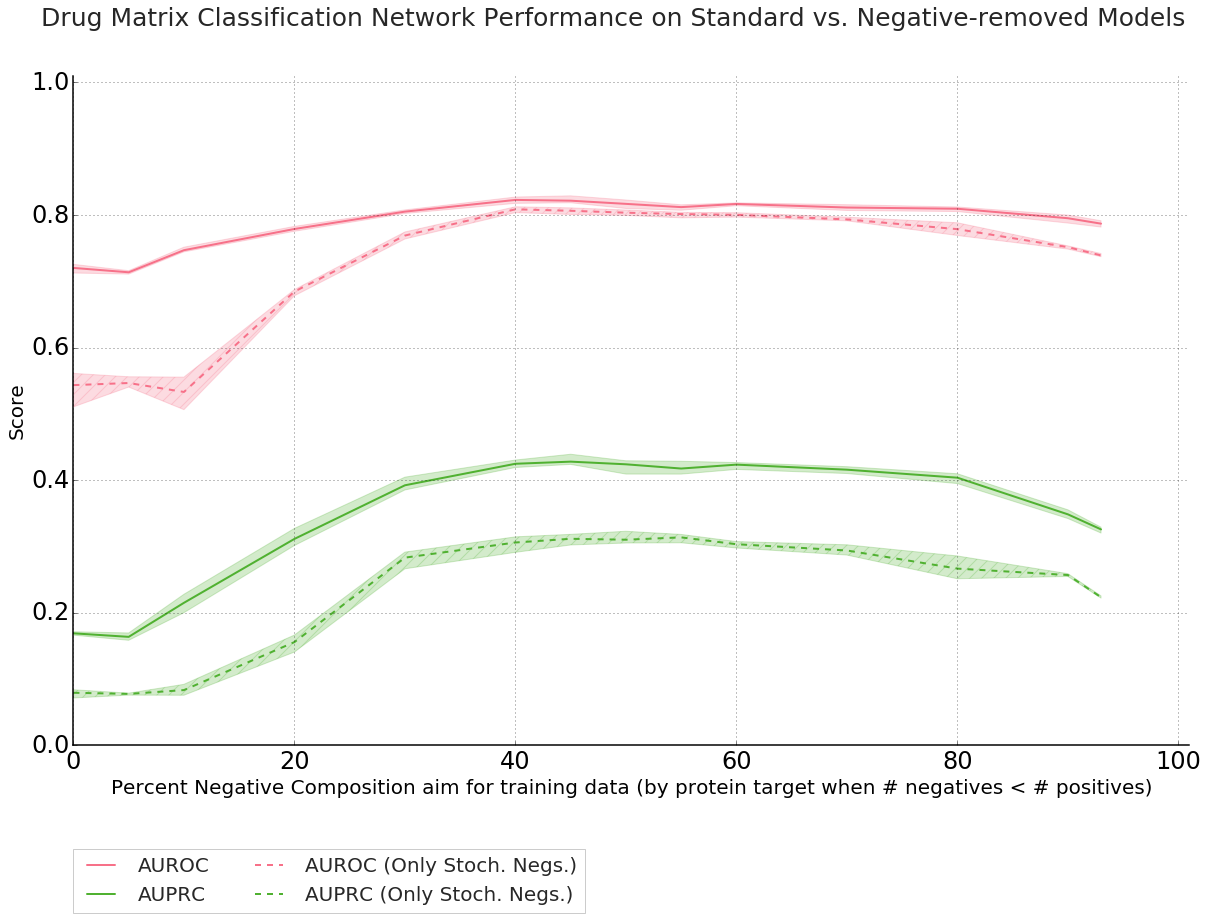

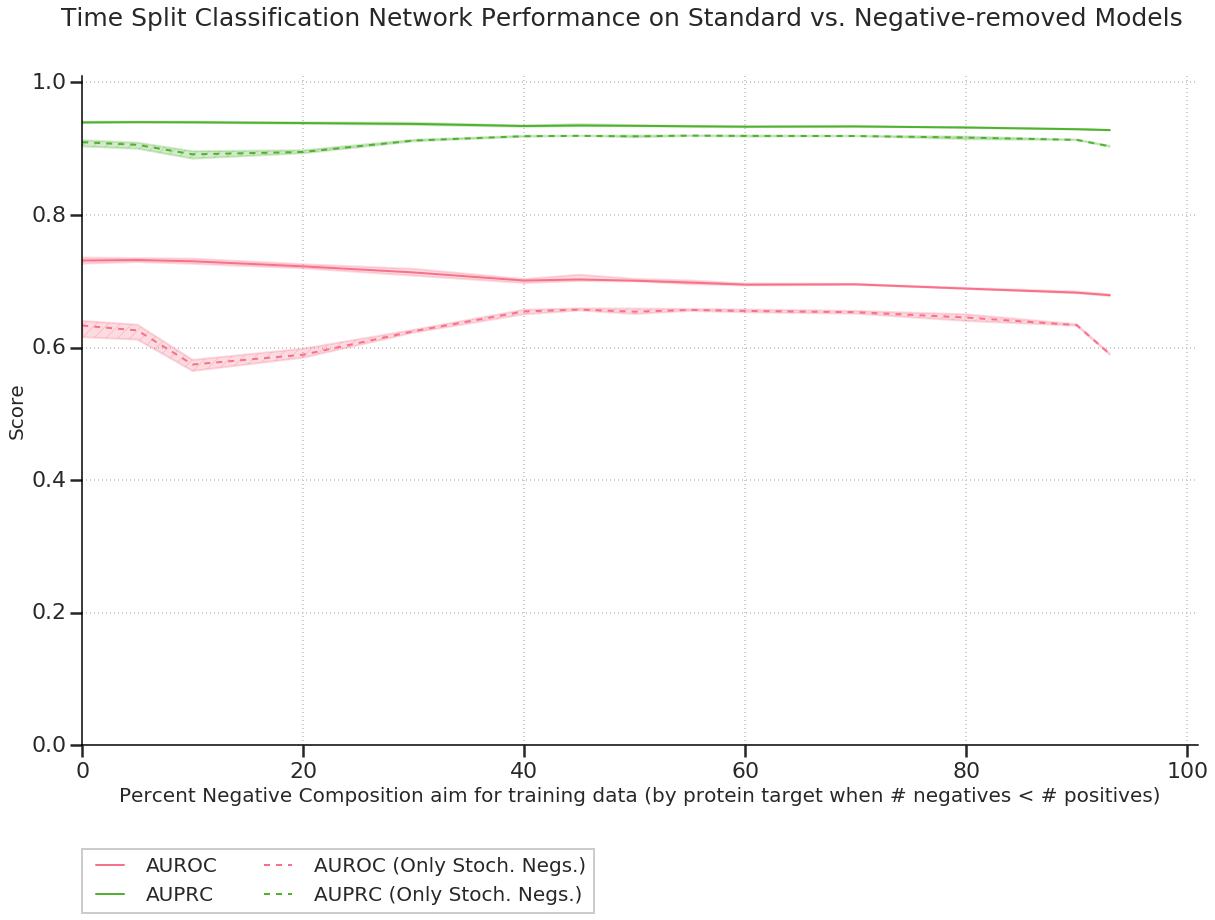

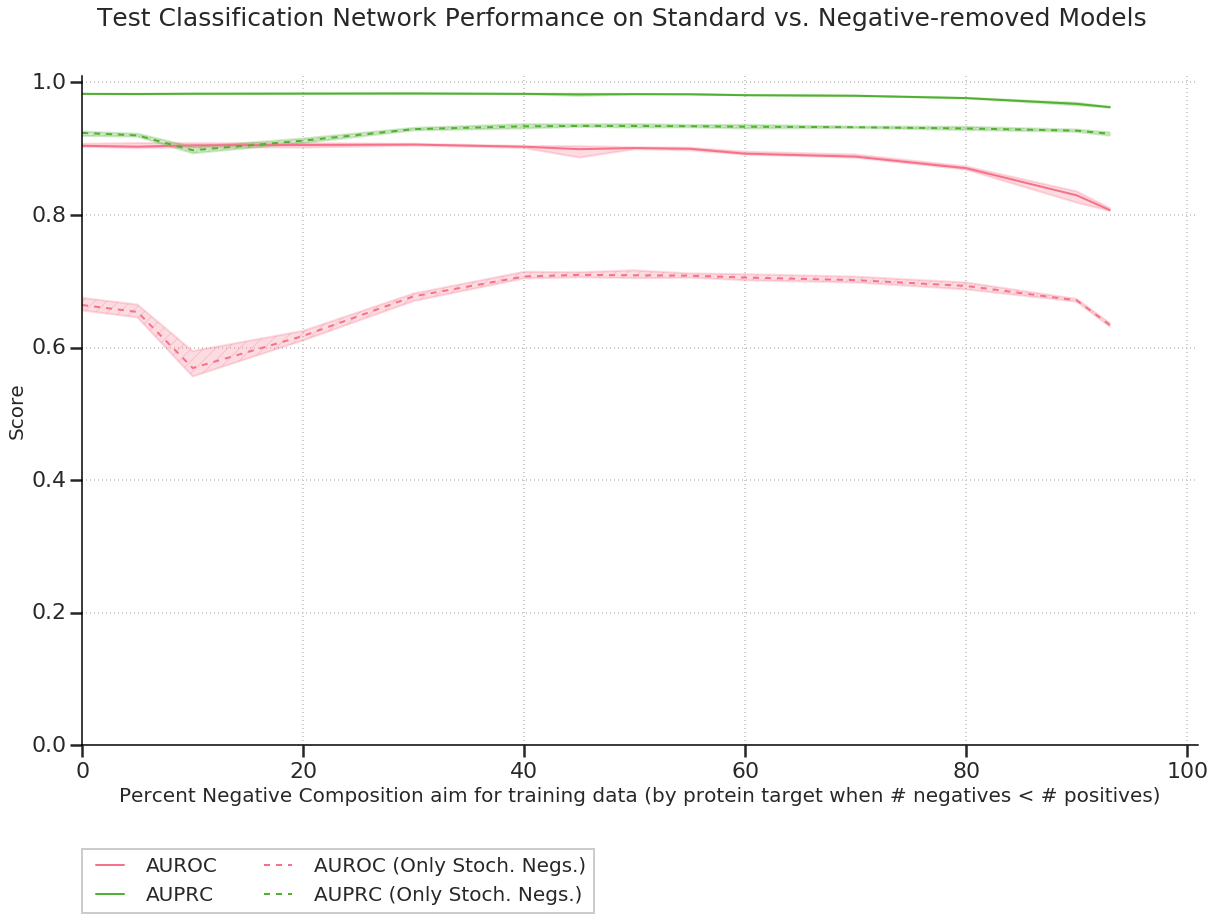

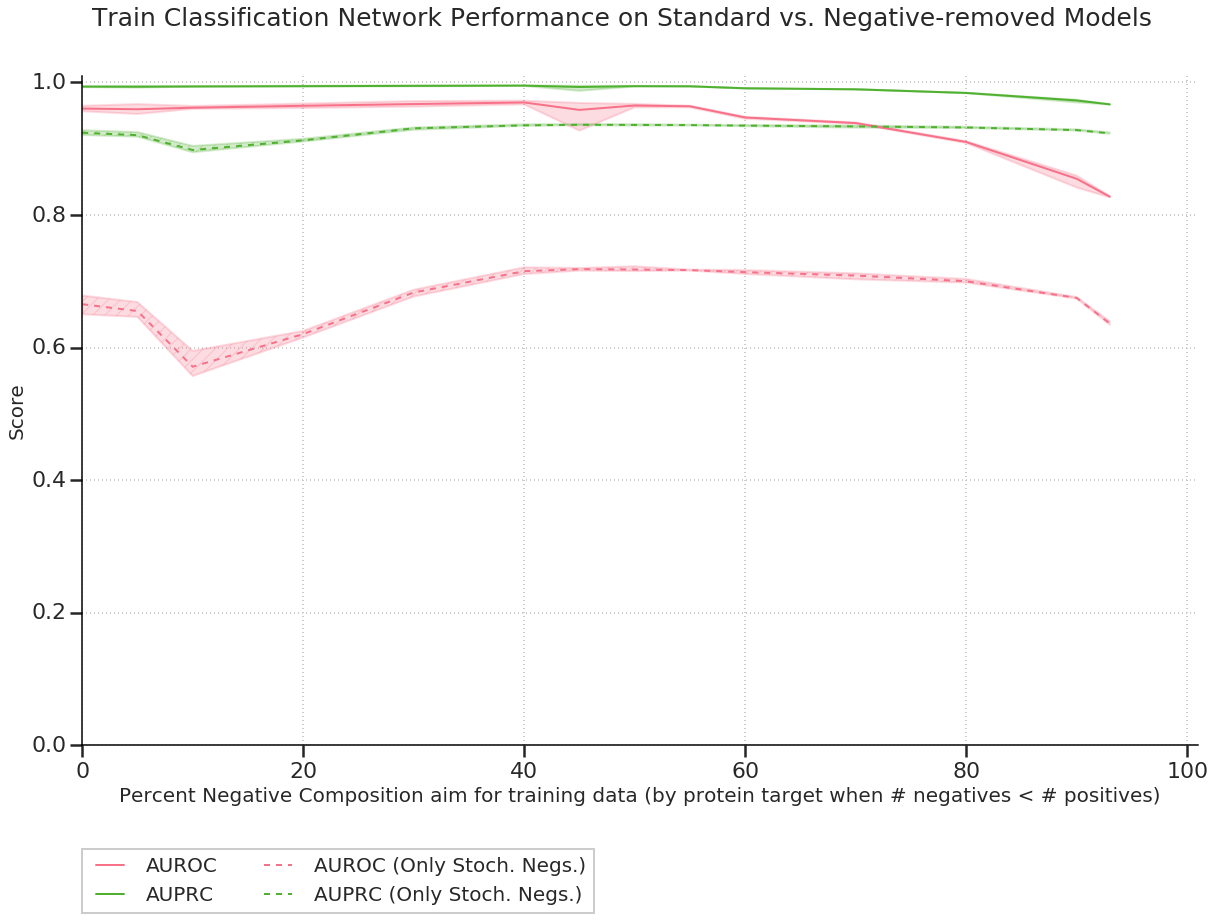

In [18]:
axes_size = 20
legend_size= 20
legend_col = 2
title_size=25

name_dict = {
    "drugmatrix" : "Drug Matrix",
    "timesplit" : "Time Split",
    "test" : "Test",
    "train" : "Train",
}

metrics = ["AUROC", "AUPRC"]
metric_names = metrics

dsets = ["drugmatrix", "timesplit", "test", "train"]


for d in dsets:
    fig, ax = plt.subplots(figsize=(20,12))
    sns.set_style("whitegrid")
    palette = sns.color_palette("husl", len(metrics)+1)

    plot_metrics_by_pnr(sma_resdf[sma_resdf["dset"]==d], metrics, metric_names=metric_names, palette=palette,)
    plot_metrics_by_pnr(neg_resdf[neg_resdf["dset"]==d], metrics, metric_names=metric_names, palette=palette, label_suffix=' (Only Stoch. Negs.)', linestyle='--', hatch='//')
    set_nice_spines(ax=ax)
#     plt.title(d, fontsize=30)
    
    plt.ylim(ymin=0.)
    sns.despine()
    set_nice_spines(ax)
    ax.xaxis.grid(True, which='major', linestyle=':') 
    ax.set_xlim(0,101)
    ax.set_ylim(0,1.01)

    ax.yaxis.grid(True, which='major', linestyle=':')
    ax.tick_params(top=False, right=False)

    plt.suptitle('{} Classification Network Performance on Standard vs. Negative-removed Models'.format(name_dict[d]), size=title_size)
    plt.xlabel('Percent Negative Composition aim for training data (by protein target when # negatives < # positives)', size=axes_size)
    plt.ylabel('Score', size=axes_size)
    plt.legend(loc='lower center')
    plt.legend(bbox_to_anchor=(0, -0.25), loc=3, borderaxespad=0., fontsize=legend_size, ncol=legend_col)
    sns.set_context("poster")
    plt.show()
#     save_dir = "{}/paper_figs".format(get_env_var("HOME"))
#     plt.savefig("{}/{}_classification_SNA_ratios.png".format(save_dir, d), dpi=300)
#     plt.clf()

In [19]:
grouped = sma_resdf.groupby(["expt", "dset", "positive_negative_ratio", "enforced_neg_percent", "ppos"])
g1 = grouped.mean()
g2 = grouped.std()
g2.columns = ["fold_std", "AUROC std", "AUPRC std"]

In [20]:
sma_ratio_df = pd.merge(g1.reset_index(), g2.reset_index(), on=["expt", "dset", "positive_negative_ratio", 
                                                                "enforced_neg_percent", "ppos"])

In [21]:
grouped = neg_resdf.groupby(["expt", "dset", "positive_negative_ratio", "enforced_neg_percent", "ppos"])
g1 = grouped.mean()
g2 = grouped.std()
g2.columns = ["fold_std", "AUROC std", "AUPRC std"]

In [22]:
neg_ratio_df = pd.merge(g1.reset_index(), g2.reset_index(), on=["expt", "dset", "positive_negative_ratio", 
                                                                "enforced_neg_percent", "ppos"])

In [23]:
all_df = pd.concat([sma_ratio_df, neg_ratio_df]).groupby(["dset", "expt", "positive_negative_ratio", 
                                                                "enforced_neg_percent", "ppos"]).mean()

In [24]:
all_df = all_df[['AUROC', 'AUROC std', 'AUPRC', 'AUPRC std']]

In [25]:
all_df.to_csv("{}/all_ratio_plot_mean_std.csv".format(plot_data_save_base), sep='\t', index=True)

In [20]:
"{}/all_ratio_plot_mean_std.csv".format(plot_data_save_base)

'/srv/nas/mk1/users/ecaceres//20190410_SMA_Investigation/plot_data/classification/all_ratio_plot_mean_std.csv'

In [26]:
all_df

AUROC  \
dset       expt                         positive_negative_ratio enforced_neg_percent ppos                   
drugmatrix CLASSIFIER_NEG_RM_SMA_RATIOS 0.0000                  0.000000             100.000000  0.543427   
                                        0.0753                  92.997303            7.002697    0.739085   
                                        0.1111                  90.000900            9.999100    0.751544   
                                        0.2500                  80.000000            20.000000   0.778676   
                                        0.4286                  69.998600            30.001400   0.793386   
                                        0.6666                  60.002400            39.997600   0.800307   
                                        0.8182                  54.999450            45.000550   0.801429   
                                        1.0000                  50.000000            50.000000   0.803516   
                                        1.2222                  45.000450            54.999550   0.806390   
                                        1.5000                  40.000000            60.000000   0.808624   
                                        2.3333                  30.000300            69.999700   0.769034   
                                        4.0000                  20.000000            80.000000   0.684569   
                                        9.0000                  10.000000            90.000000   0.533128   
                                        19.0000                 5.000000             95.000000   0.546601   
           CLASSIFIER_SMA_RATIOS        0.0000                  0.000000             100.000000  0.720208   
                                        0.0753                  92.997303            7.002697    0.786986   
                                        0.1111                  90.000900            9.999100    0.795166   
                                        0.2500                  80.000000            20.000000   0.809474   
                                        0.4286                  69.998600            30.001400   0.811311   
                                        0.6666                  60.002400            39.997600   0.816704   
                                        0.8182                  54.999450            45.000550   0.811936   
                                        1.0000                  50.000000            50.000000   0.816827   
                                        1.2222                  45.000450            54.999550   0.821627   
                                        1.5000                  40.000000            60.000000   0.822802   
                                        2.3333                  30.000300            69.999700   0.805109   
                                        4.0000                  20.000000            80.000000   0.778943   
                                        9.0000                  10.000000            90.000000   0.746958   
                                        19.0000                 5.000000             95.000000   0.713622   
test       CLASSIFIER_NEG_RM_SMA_RATIOS 0.0000                  0.000000             100.000000  0.664201   
                                        0.0753                  92.997303            7.002697    0.634156   
...                                                                                                   ...   
timesplit  CLASSIFIER_SMA_RATIOS        9.0000                  10.000000            90.000000   0.730225   
                                        19.0000                 5.000000             95.000000   0.732124   
train      CLASSIFIER_NEG_RM_SMA_RATIOS 0.0000                  0.000000             100.000000  0.665493   
                                        0.0753                  92.997303            7.002697    0.636341   
                                        0.1111                  90.